### pytorchの仕様について
デフォルトでは小数4桁に丸めて表示される\
以下のコードを用いることで表示桁数を変えることが可能(nの部分が該当)\
torch.set_printoptions(precision = n , sci_mode = False)\
つまり、表示の桁数はいくらでも変えることは可能であり、値そのものや計算結果には影響を与えない

### 計算について
PyTorch（およびほとんどの数値計算ライブラリ）は、デフォルトで 32ビット浮動小数点数（torch.float32） を使用
float32の有効桁数が小数7桁程度なのでその辺りまでが実際に有効な値\
有効桁数を減らすにはfloat16にすればよい。小数4桁ぐらいの精度になる\



In [1]:
# ### 活性化関数に使用するClipped ReLU
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.nn.functional as F

# # クリップReLUの定義
# def clipped_relu(x, clip_value=1.0):
#     return torch.clamp(F.relu(x), max=clip_value)

# # 描画用データ
# x = torch.linspace(-2, 2, 500)  # 入力値
# clip_value = 1.0  # クリップする最大値
# y = clipped_relu(x, clip_value=clip_value)  # クリップReLUの適用

# # 描画
# plt.figure(figsize=(8, 6))
# plt.plot(x.numpy(), y.numpy(), label=f"Clipped ReLU (clip value={clip_value})", color="blue")
# plt.axhline(clip_value, color="red", linestyle="--", label="Clip value")
# plt.axhline(0, color="gray", linestyle="--", alpha=0.6)
# plt.axvline(0, color="gray", linestyle="--", alpha=0.6)
# plt.title("Clipped ReLU Activation Function")
# plt.xlabel("Input")
# plt.ylabel("Output")
# plt.legend()
# plt.grid()
# plt.show()



In [2]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import signal
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from google.colab import drive

In [3]:
# ドライブのマウント
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
### ファイル名(times)とそれに該当するサイズ
# number 1~5 L
# number 6~10 M
# number 11~15 S

In [5]:
### 移動平均
def moving_average(data, window_size=100):
    return data.rolling(window=window_size, center=True).mean()


### ローパスフィルタ
def apply_lowpass_filter(data, samplerate=1000, fp=30, fs=50, gpass=1, gstop=50):
    """
    ローパスフィルタをデータに適用する関数

    :param data: フィルタリング対象のデータ (Pandas DataFrame)
    :param samplerate: サンプリングレート (Hz)
    :param fp: 通過域端周波数 (Hz)
    :param fs: 阻止域端周波数 (Hz)
    :param gpass: 通過域最大損失量 (dB)
    :param gstop: 阻止域最小減衰量 (dB)
    :return: フィルタリングされたデータ (Pandas DataFrame)
    """
    fn = samplerate / 2  # ナイキスト周波数
    Wp = fp / fn  # 正規化通過域端周波数
    Ws = fs / fn  # 正規化阻止域端周波数

    # バターワースフィルタの設計
    N, Wn = signal.buttord(Wp, Ws, gpass, gstop)
    b, a = signal.butter(N, Wn, 'low')

    # フィルタの適用
    filtered_data = data.copy()
    for col in filtered_data.columns:
        filtered_data[col] = signal.filtfilt(b, a, filtered_data[col]) # ローパスフィルタの適用
        # filtered_data[col] = moving_average(filtered_data[col]) # 移動平均の適用

    return filtered_data

### ノイズを追加する関数
# データ複製時に使用
def add_noise(data, noise_level=0.5):
    """データにノイズを付加する"""
    numeric_data = data.select_dtypes(include=np.number)  # 数値列を抽出
    noise = np.random.normal(0, noise_level, numeric_data.shape)  # ノイズを生成
    noisy_data = numeric_data + noise  # 元データにノイズを加える
    noisy_data = pd.DataFrame(noisy_data, columns=numeric_data.columns)  # データフレーム化
    return pd.concat([noisy_data, data.drop(columns=numeric_data.columns)], axis=1)  # クラス列を結合


In [6]:
class CustomDataset(Dataset):
    def __init__(self,  materials, times, base_path, corrupted_files, window_size=500, overlap=250):
      '''
      :param materials: 素材名
      :times: 試行回数
      :corrupted_files: 破損ファイル
      :window_size: 切り出す際のウィンドウサイズ
      :overlap: 切り出す際のオーバーラップサイズ
      '''
      self.materials = materials
      self.times = times
      self.base_path = base_path
      self.corrupted_files = corrupted_files
      self.window_size = window_size
      self.overlap = overlap
      self.labels = [] # ラベルを格納
      self.windows_all_data = [] # 切り出し後の全データを格納
      self.windowed_data = {} # 切り出し後のデータをクラスごとに格納
      self.data = self.load_data()



    # データの読み込み、複製、ウィンドウ切り出し
    def load_data(self):
        # 素材ごとにデータを連結
        for material in materials:
            combined_data = pd.DataFrame()  # 素材ごとのデータを結合するDataFrame

            for time in times:
                file_path = os.path.join(base_path, material, f'{material}_single1ch25Mdigital{time}_count.csv')  # ファイルパス

                # 破損ファイルをスキップ
                if f'{material}_single1ch25Mdigital{time}_count.csv' in corrupted_files:
                    print(f'{file_path} は破損しているためスキップします')
                    continue

                # データの処理
                if os.path.exists(file_path):
                    try:
                        # データを読み込む
                        data = pd.read_csv(file_path, skiprows=1, header=None)  # 最初の行をスキップ(1行目にdata情報がある場合に使用。ない場合はskiprowsを0に変更)

                        # ノイズ除去
                        filtered_data = apply_lowpass_filter(data, samplerate=500) # ローパスフィルタの適用
                        filtered_data = filtered_data.reset_index(drop=True) # インデックスの再設定
                        filtered_data = filtered_data.dropna() # nan値の処理

                        # 素材ごとの結合データに追加
                        combined_data = pd.concat([combined_data, filtered_data], ignore_index=True)

                    except Exception as e:
                        print(f"エラー内容: {type(e).__name__}, {e}")
                else:
                    error_file_name = os.path.basename(file_path)
                    print(f'{error_file_name} のデータが見つかりませんでした')

            ### データの笠増し
            # 元データを10倍に拡張する（ノイズを加えたデータを繰り返す）
            dublicated_data = pd.DataFrame()
            for _ in range(9):  # 9回繰り返して10倍に
                noisy_data = add_noise(combined_data, noise_level=0.1)  # ノイズを追加
                dublicated_data = pd.concat([dublicated_data, noisy_data], ignore_index=True) # データを結合

            # クラスラベル（素材名）を追加
            dublicated_data['class'] = material


            # データ数確認
            print(f"{material} has {len(dublicated_data)} points before subsampling.")

            # 元データを50個おきにサンプリング
            # de_combined_data = dublicated_data.iloc[::50].reset_index(drop=True)

            # サブサンプリング無し
            de_combined_data = dublicated_data

            # サンプリング後のデータ数を確認
            print(f"{material} has {len(de_combined_data)} points after sampling.")

            # 平均値を0にする処理
            nor_de_combined_data = pd.DataFrame()
            numeric_columns = de_combined_data.select_dtypes(include='number').columns
            for col in numeric_columns:
                nor_de_combined_data[col] = de_combined_data[col] - de_combined_data[col].mean()


            ### windowの切り出し
            # class_windowsに切り出しデータを一時的に保存
            class_windows = [
                nor_de_combined_data.iloc[i:i + self.window_size]
                for i in range(0, len(nor_de_combined_data) - self.window_size + 1, self.window_size - self.overlap)
            ]

            # 一括でデータを保存
            self.windowed_data[material] = class_windows # 素材ごとにwindowをまとめた辞書（素材ごとの描画に使用)
            self.windows_all_data.extend(class_windows) # すべての素材のwindowデータを平坦化して保存するリスト(学習データに使用)
            self.labels.extend([label_mapping[material]] * len(class_windows)) # windowデータに対応するラベルのリスト(学習データに使用)　# mappingで数値ラベルを追加（文字列から整数に変換）


            # window切り出し後のデータ数の確認
            print(f"{material} has {len(class_windows)} windows.")


            ### 前処理後のデータを全体描画
            plt.figure(figsize=(20, 6))
            numeric_columns = nor_de_combined_data.select_dtypes(include='number').columns

            # 数値列（ここでは1列）を描画
            for col in numeric_columns[:1]:  # 必要なら [:1] を削除してすべての列を描画
                plt.plot(nor_de_combined_data.index, nor_de_combined_data[col], label=f'Feature {col} with Noise')

            # グラフの詳細設定
            plt.title(f'Augmented Features for {material}')
            plt.xlabel('Sample Index')
            plt.ylabel('Amplitude')
            plt.legend(loc='upper right')
            plt.grid(True)
            plt.tight_layout()
            plt.show()


    # データセットの長さを取得(window数)
    def __len__(self):
        return len(self.windows_all_data)

    # データセットを取得
    def __getitem__(self, idx):
        data = self.windows_all_data[idx]  # windowデータ
        label = self.labels[idx]  # ラベル

        # ラベルもテンソルに変換
        label_tensor = torch.tensor(label, dtype=torch.long)  # ラベルは通常整数型（分類タスクの場合）

        return torch.tensor(data.values, dtype=torch.float32), label_tensor # 今回はfloat32で定義


    # クラスごとにwindowを描画
    def plot_windows_by_class(self, n_windows=3):
        # クラスごとにプロットを作成
        for material, class_windows in self.windowed_data.items():
            if len(class_windows) == 0:
                print(f"No windows available for class: {material}")
                continue

            # 画像を1つ作成
            plt.figure(figsize=(24, 6))  # 図のサイズを設定

            # サブプロットの数を決める
            n_subplots = min(n_windows, len(class_windows))
            for i in range(n_subplots):
                window = class_windows[i]  # 各ウィンドウを選択

                # x軸（時間軸）を作成
                time = np.arange(len(window))  # サンプルインデックス（0, 1, 2, ..., 499）

                # サブプロットの設定
                plt.subplot(1, n_subplots, i+1)  # 1行n_subplots列で配置
                # 最初のウィンドウにだけラベルを付ける
                if i == 0:
                    plt.plot(time, window.iloc[:, 0], label=f'Feature 1')  # 最初の列（1列のみ）のデータを描画
                else:
                    plt.plot(time, window.iloc[:, 0])  # それ以外はラベルなしで描画

                plt.title(f'Window {i+1}')
                plt.xlabel('Time (Sample Index)')
                plt.ylabel('Amplitude')
                plt.grid(True)  # グリッドを表示
                if i == 0:  # 最初のサブプロットでのみ凡例を表示
                    plt.legend(loc='upper right')  # ラベルを右上に配置

            # クラス名をタイトルに設定
            plt.suptitle(f'Random {n_subplots} Windows for Class: {material}')
            plt.tight_layout()  # レイアウトを調整
            plt.subplots_adjust(top=0.85)  # suptitleとの重なりを防ぐために調整
            plt.show()

curve has 7550379 points before subsampling.
curve has 7550379 points after sampling.
curve has 603 windows.


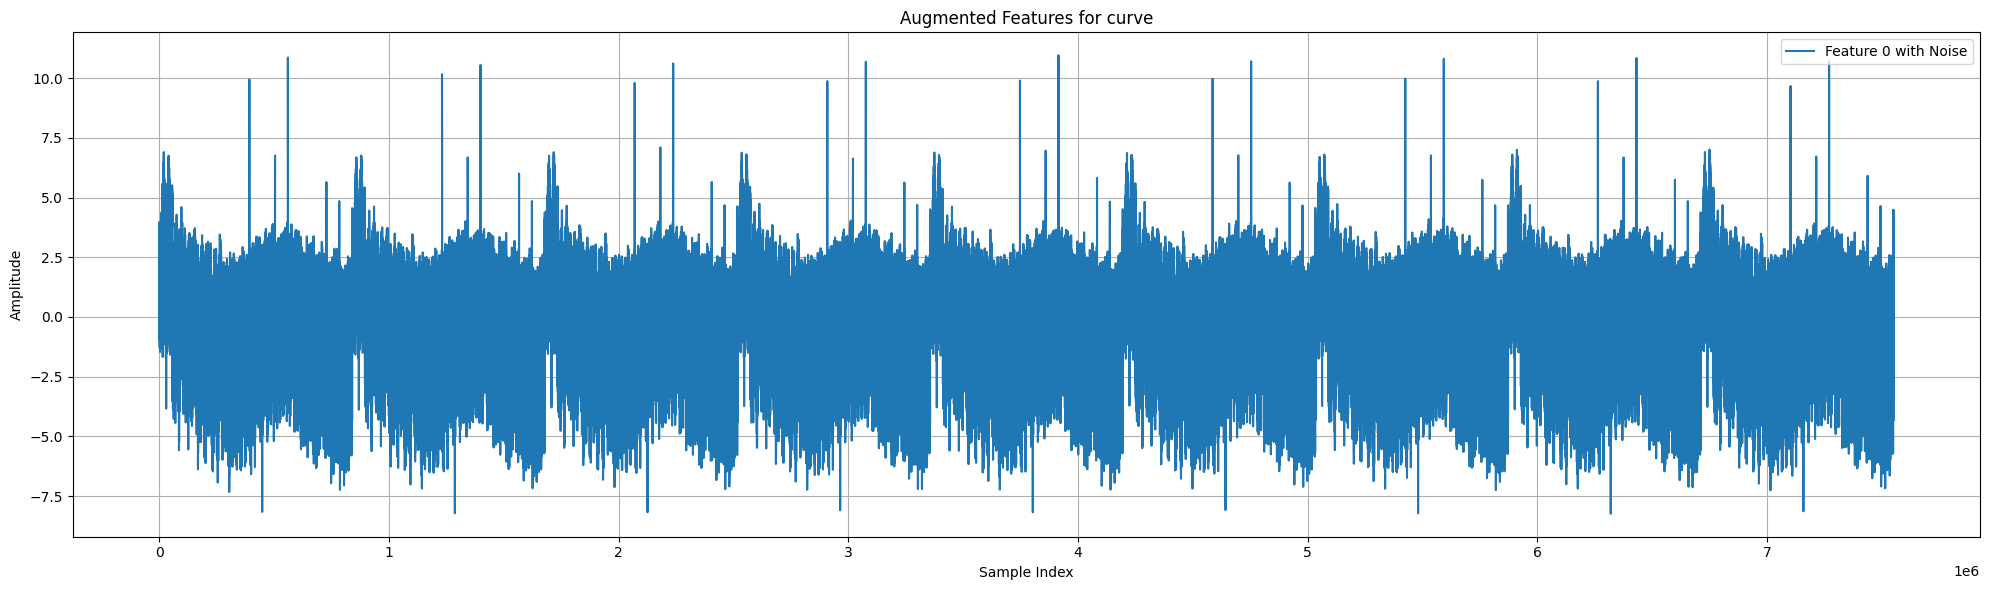

edge has 7557426 points before subsampling.
edge has 7557426 points after sampling.
edge has 603 windows.


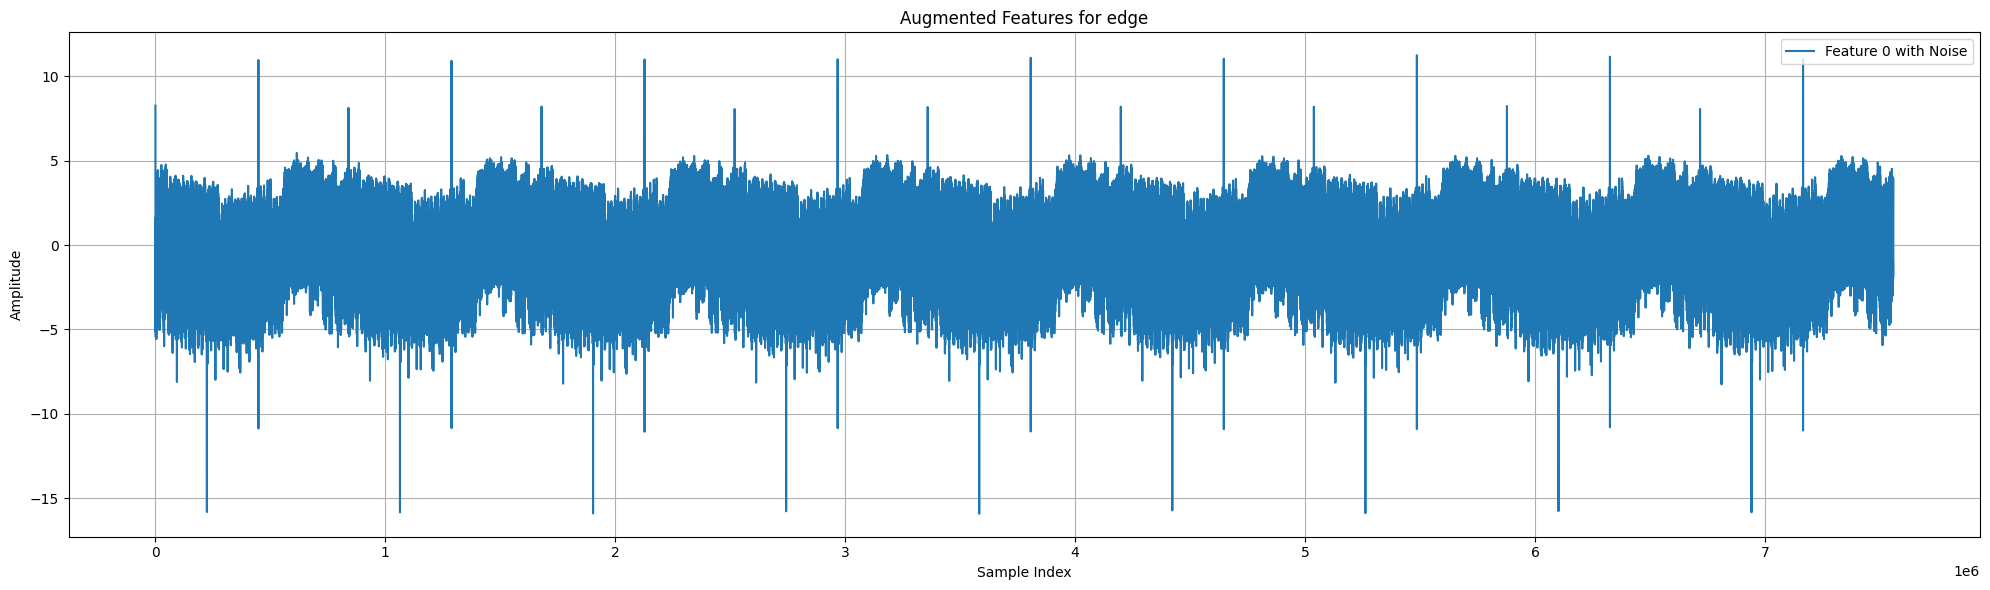

saw has 7553223 points before subsampling.
saw has 7553223 points after sampling.
saw has 603 windows.


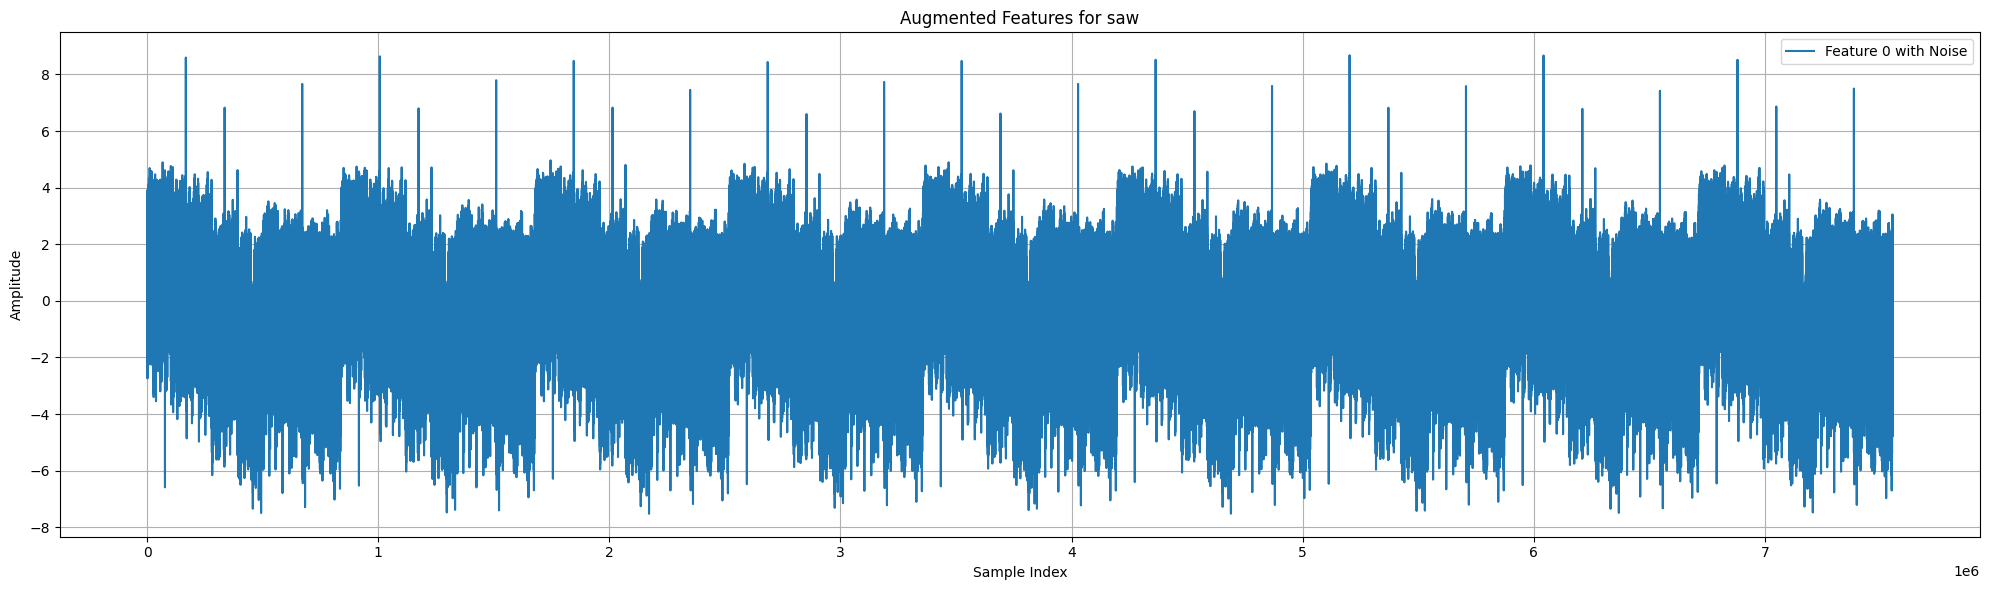

square has 7554339 points before subsampling.
square has 7554339 points after sampling.
square has 603 windows.


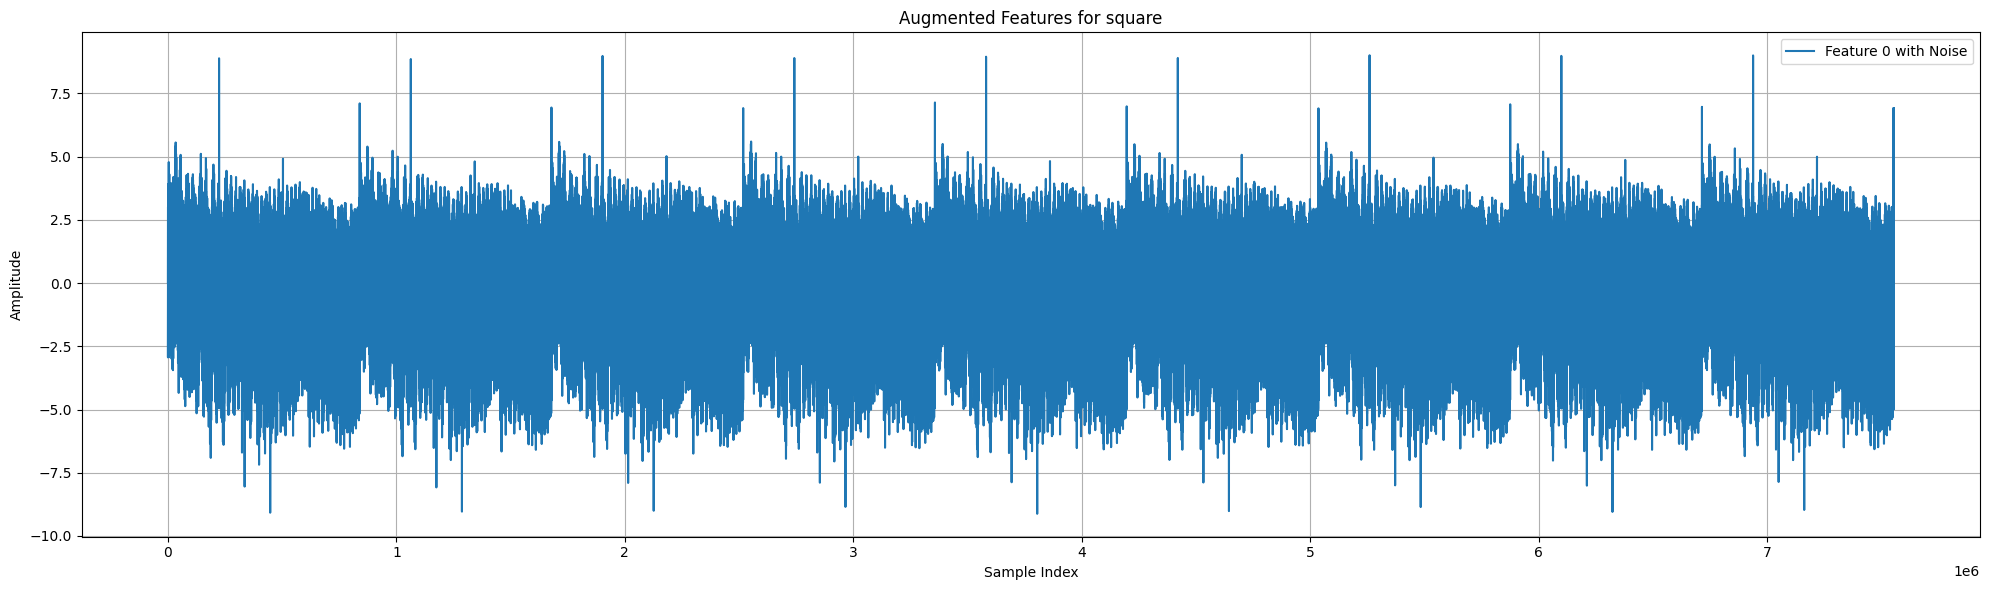

Dataset size: 2412


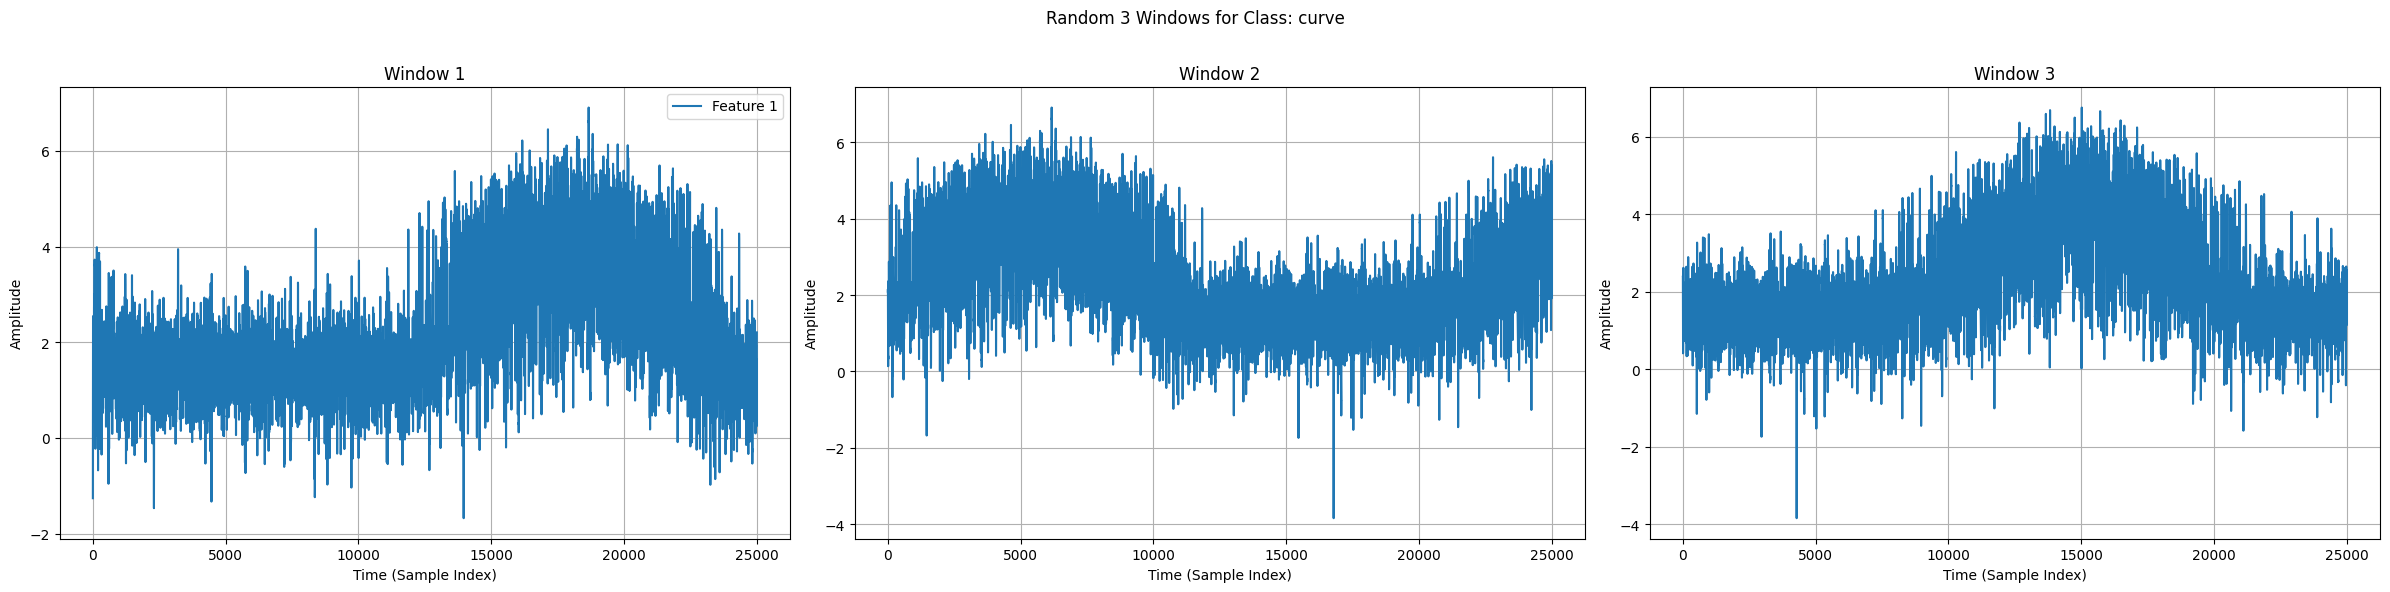

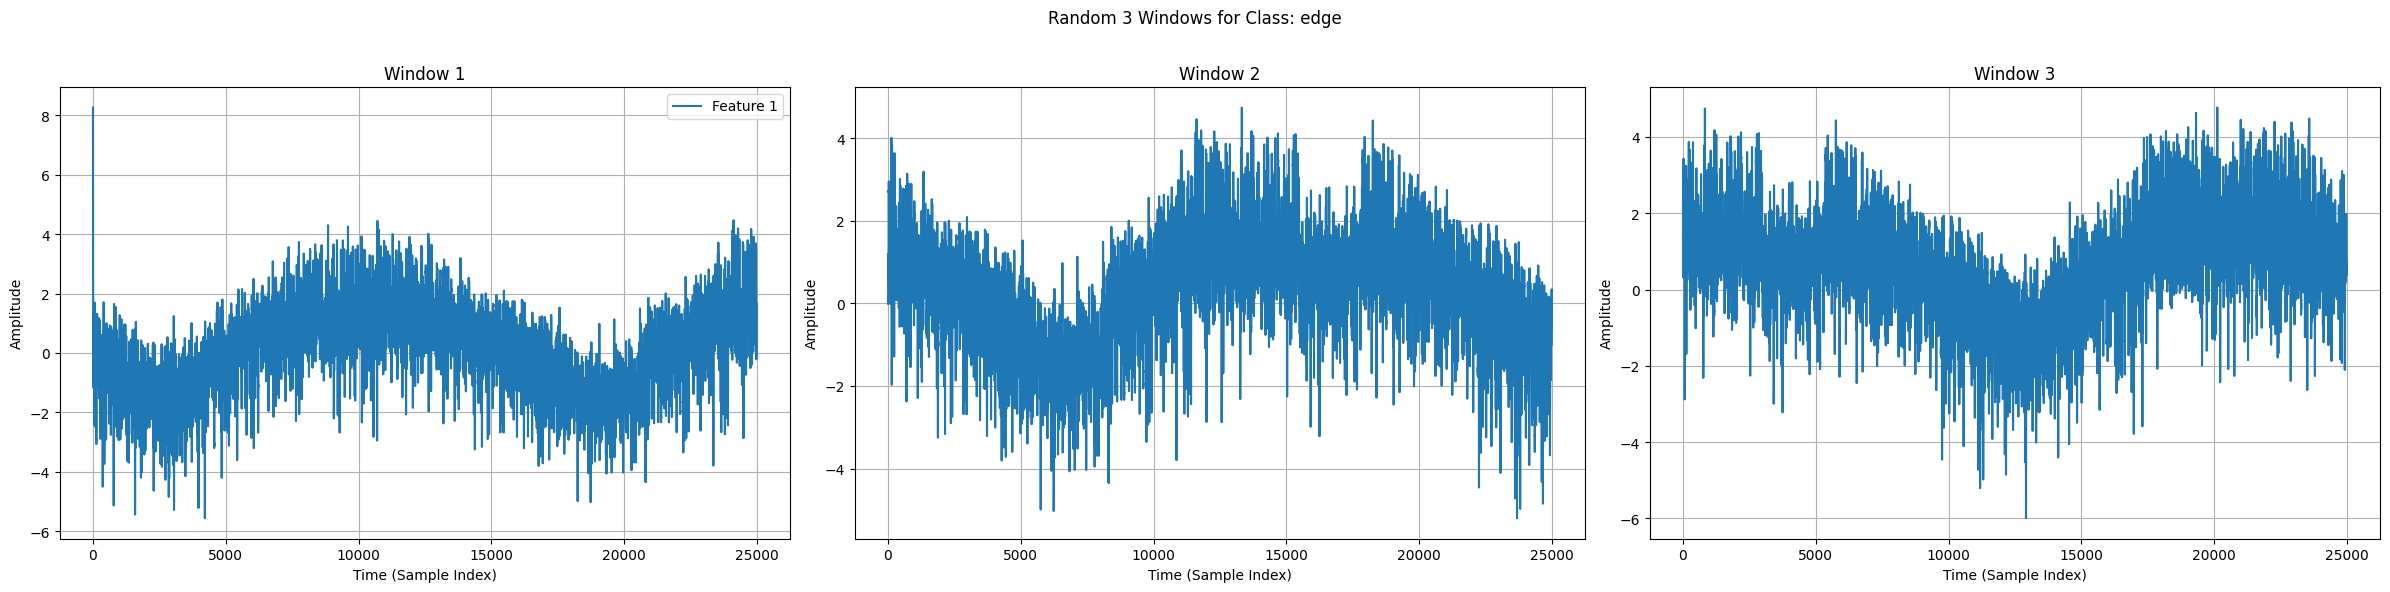

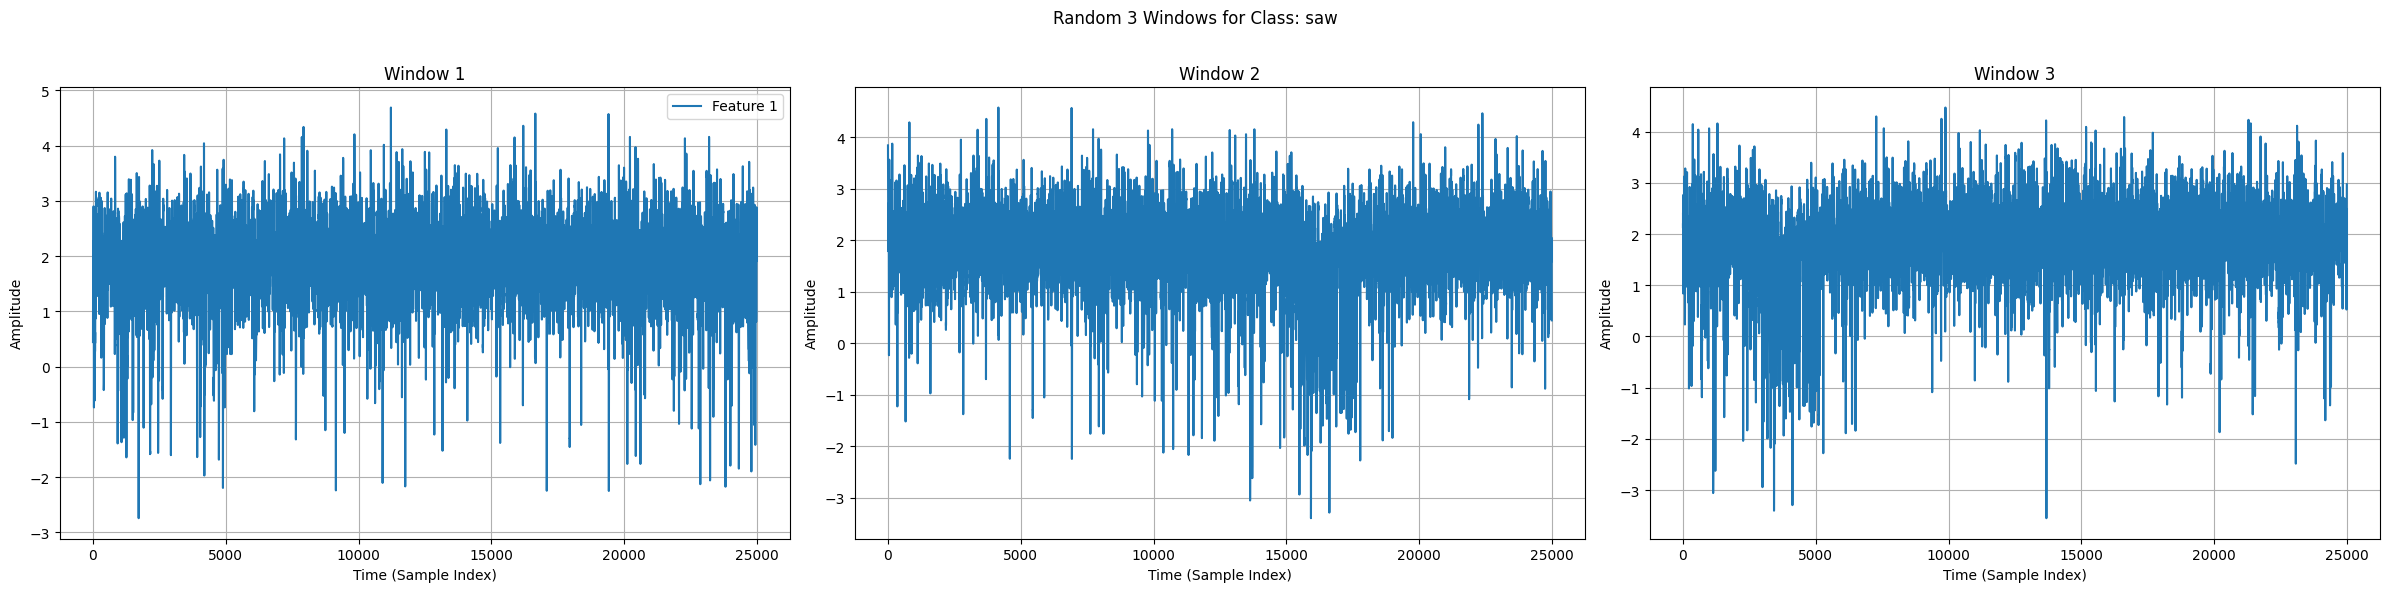

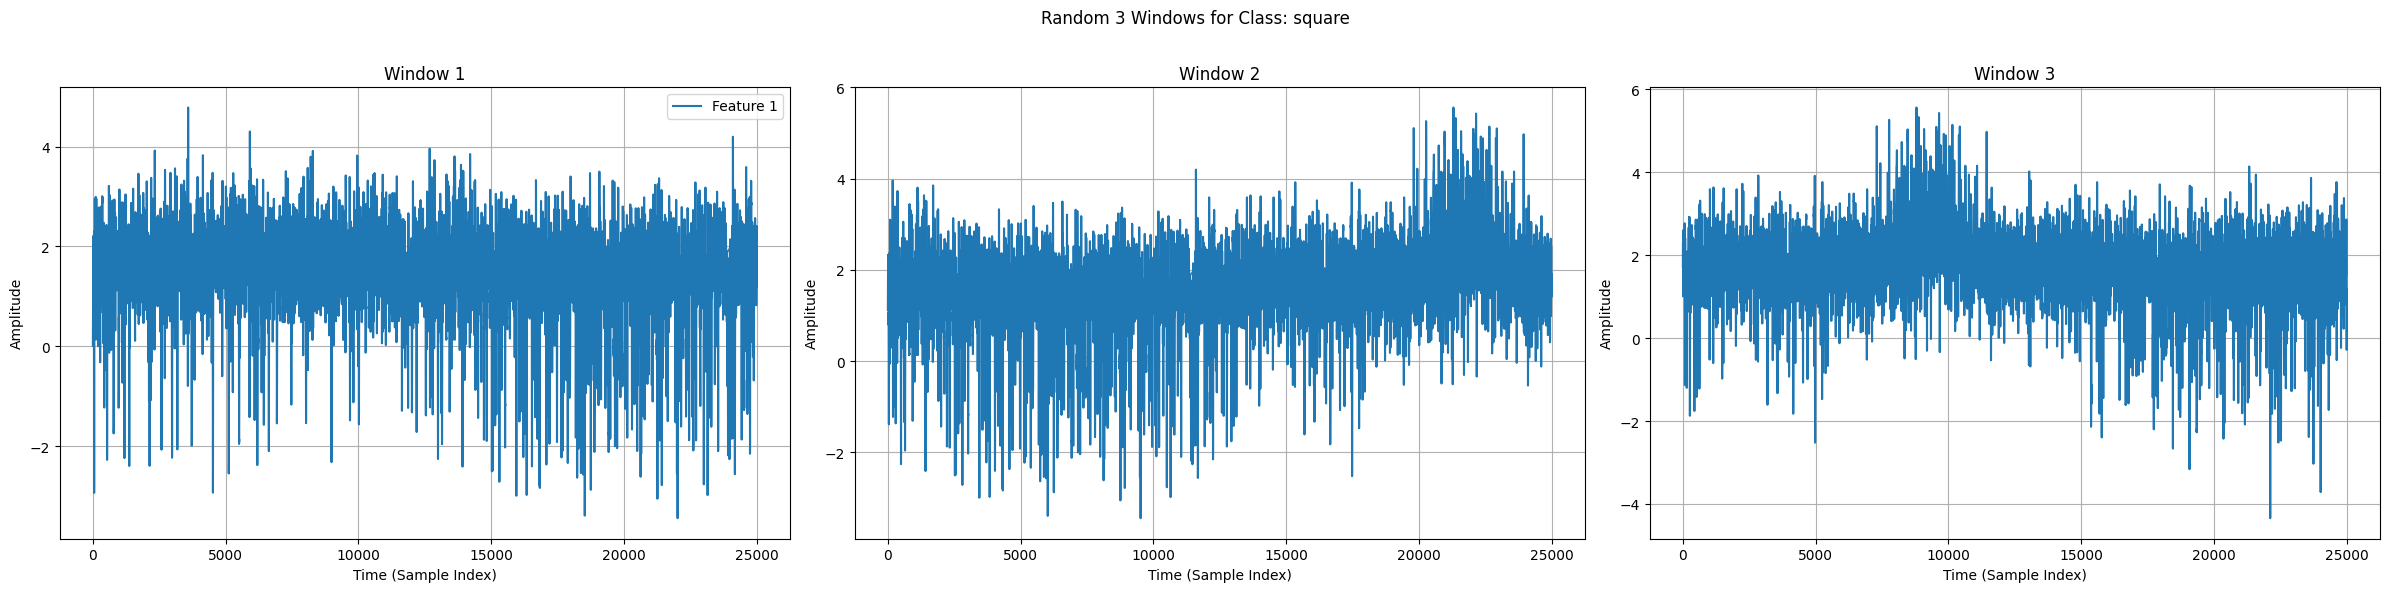

In [7]:
### ノイズ追加＆データ複製 カスタムDatasetクラスの定義

# クラスラベルのマッピングを定義
label_mapping = {'curve': 0, 'edge': 1, 'saw': 2, 'square': 3}

# 実際のフォルダとファイル名を指定
base_path = 'drive/MyDrive/COUNT'
materials = ['curve', 'edge', 'saw', 'square']  # 素材のフォルダ名
times = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']  # 試行回数

# 破損ファイル
corrupted_files = [] # 今回は無し

# カスタムデータセットをインスタンス
dataset = CustomDataset(materials, times, base_path, corrupted_files, window_size=25000, overlap=12500)
# データセットの長さを確認
print(f"Dataset size: {len(dataset)}")


# 0番目のウィンドウを描画
dataset.plot_windows_by_class(n_windows=3)



In [8]:
# データセットの長さ
dataset_size = len(dataset)

# 訓練データと検証データに分割(訓練：検証　８：２)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # 訓練データは順番をシャッフル
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # 検証データはシャッフル無し

# データ形状確認（訓練データ）
for batch_data, batch_labels in train_loader:
    print(f"Train Batch data shape: {batch_data.shape}")
    print(f"Train Batch labels shape: {batch_labels.shape}")
    break  # 最初のバッチだけ確認

# データ形状確認（検証データ）
for batch_data, batch_labels in val_loader:
    print(f"Val Batch data shape: {batch_data.shape}")
    print(f"Val Batch labels shape: {batch_labels.shape}")
    break  # 最初のバッチだけ確認

# データ数描画
print(f"full: {len(dataset)} -> train: {len(train_dataset)}, test: {len(val_dataset)}")


Train Batch data shape: torch.Size([32, 25000, 1])
Train Batch labels shape: torch.Size([32])
Val Batch data shape: torch.Size([32, 25000, 1])
Val Batch labels shape: torch.Size([32])
full: 2412 -> train: 1929, test: 483


**以下より学習モデル**

In [9]:
# 恒等写像
def identity(x):
    return x  # pytorchのテンソルをそのまま処理可能


### 入力層の定義
class Input(nn.Module):
    def __init__(self, N_u, N_x, input_scale, seed=0):
        '''
        param N_u: 入力次元
        param N_x: リザバーのノード数
        param input_scale: 入力スケーリング
        '''
        super(Input, self).__init__()
        # 一様分布に従う乱数
        torch.manual_seed(seed)
        self.Win = nn.Parameter(
            torch.empty((N_u, N_x), dtype=torch.float32).uniform_(-input_scale, input_scale)
        )
        self.Win.requires_grad = False  # 勾配更新を不要にする

    def get_weight_matrix(self):
        # 入力行列Winを返す
        return self.Win

### Winの形を確認するには　print(input_layer.Win.dtype)  # 出力: torch.float32　を使用

In [10]:
### リザバー層の定義
class Reservoir(nn.Module):
    def __init__(self, N_x, density, rho, activation_func, seed):
        '''
        param N_x: リザバーのノード数
        param density: ネットワークの結合密度
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: ノードの活性化関数 (torch.nn.functional)
        param seed: 乱数の種
        '''
        super(Reservoir, self).__init__()
        self.seed = seed
        self.N_x = N_x

        # リカレント結合重み行列Wを初期化(float32で作成)
        self.W = self.make_connection_pytorch(N_x, density, rho, seed)
        self.W = nn.Parameter(self.W)  # Wをnn.Parameterとして管理
        self.W.requires_grad = False  # リザバーの重みは訓練しない

        # リザバー状態ベクトルの初期化(今回はfloat32で実装
        self.x = torch.zeros(N_x, dtype=torch.float32)

        # ノードの活性化関数を設定
        self.activation_func = activation_func


    @staticmethod
    def make_connection_pytorch(N_x, density, rho, seed):
        '''
        リカレント結合重み行列 W を生成

        param N_x: リザバーのノード数 (int)
        param density: ネットワークの結合密度 (float, 0〜1)
        param rho: スペクトル半径 (float)
        param seed: 乱数の種 (int)
        return: リカレント結合重み行列 W (torch.Tensor, float32)
        '''
        torch.manual_seed(seed)

        # ランダムな接続行列の生成(ベルヌーイ分布に基づく行列)
        connection = torch.bernoulli(torch.full((N_x, N_x), density))

        # 各重みを一様分布で初期化
        rec_scale = 1.0
        W = connection * (torch.rand((N_x, N_x)) * 2 * rec_scale - rec_scale)

        # Wが空でないことを確認
        if W.numel() == 0:
            raise ValueError("Weight matrix W is empty. Please check the matrix generation process.")

        # スペクトル半径を計算(Wの固有値の最大絶対値)
        eigenvalues = torch.linalg.eigvals(W)
        if eigenvalues.numel() == 0:
            raise ValueError("Eigenvalues are empty. Check the matrix W.")

        # スペクトル半径を計算
        sp_radius = torch.max(torch.abs(eigenvalues.real))

        # スペクトル半径をrhoにスケーリング
        W *= rho / sp_radius

        return W

    def get_weight_matrix_W(self):
        '''
        リカレント結合重み行列 W を返す
        return: 重み行列 W (torch.Tensor, float16)
        '''
        return self.W



In [11]:
### 出力層の定義
class Output(nn.Module):
    def __init__(self, N_x, N_y, seed=0):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param seed: 乱数の種
        '''
        super(Output, self).__init__()

        # 出力結合重み行列Woutを正規分布に従う乱数で初期化(float32)
        torch.manual_seed(seed) # 乱数シードの設定
        self.Wout = nn.Parameter(torch.randn( N_x, N_y, dtype=torch.float32)) # Woutをnn.Parameterとして定義
        self.Wout.requires_grad = True # Woutは訓練する


    def get_weight_matrix_wout(self):
        # 出力行列Woutを返す
        return self.Wout

    def setweight(self, Wout_opt):
        '''
        学習済みの出力結合重み行列を設定
        param Wout_opt: 新しい重み行列 (torch.Tensor)
        '''
        if not isinstance(Wout_opt, torch.Tensor):
            raise ValueError("Wout_opt must be a torch.Tensor.")
        self.Wout = Wout_opt


In [12]:
# 未修正
class Feedback:
    def __init__(self, N_y, N_x, fb_scale, seed=0):
        '''
        param N_y: 出力次元
        param N_x: リザバーのノード数
        param fb_scale: フィードバックスケーリング
        param seed: 乱数の種
        '''
        # 一様分布に従う乱数で初期化
        torch.manual_seed(seed)
        self.Wfb = (torch.rand(N_x, N_y, dtype=torch.float32) * 2 * fb_scale - fb_scale)

    def __call__(self, y):
        '''
        param y: N_y次元のベクトル (torch.Tensor)
        return: N_x次元のベクトル (torch.Tensor)
        '''
        return torch.matmul(self.Wfb, y)


In [13]:
# クリップReLUの定義
def clipped_relu(x, clip_value=1.0):
    return torch.clamp(F.relu(x), max=clip_value)



In [14]:
class ESN(nn.Module):
    def __init__(self, N_u, N_y, N_x, density=0.05, input_scale=1.0, rho=0.95, activation_func=clipped_relu, leaking_rate=0.2, seed = 40, clip_value = 1.0):
      '''
      param N_u: 入力層の次元数 (入力データの次元数)
      param N_y: 出力層の次元数 (分類や回帰タスクの最終出力次元)
      param N_x: リザバー層のノード数 (リザバー状態ベクトルの次元数)
      param density: リザバー層の接続密度 (結合行列のスパース性を制御)
      param input_scale: 入力重み行列のスケーリングファクタ (入力の影響度を調整)
      param rho: リザバー結合重み行列のスペクトル半径 (リザバーのダイナミクスを制御)
      param activation_func: リザバー層で使用する活性化関数 (デフォルト: tanh)
      param leaking_rate: リザバーのリーク率 (状態更新の速度を調整)
      param seed: 乱数シード (再現性のため)
      '''
      super(ESN, self).__init__()

      # デバイスの設定(GPUが利用可能であれば使用)
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      # 入力層の初期化
      self.Input = Input(N_u, N_x, input_scale).to(self.device)

      # リザバー層の初期化
      self.Reservoir = Reservoir(N_x, density, rho, activation_func, seed).to(self.device)

      # リザバー状態ベクトルの初期化(float32で定義)
      self.x_res = torch.zeros(N_x, dtype=torch.float32, device =self.device)

      # 出力層（リードアウト層）の初期化
      self.Output = Output(N_x, N_y).to(self.device)

      # 各層の次元を保存
      self.N_u = N_u # 入力次元数
      self.N_y = N_y # 出力次元数
      self.N_x = N_x # リザバー層のノード数

      # リザバー層の活性化関数とリーク率
      self.activation_func = activation_func
      self.alpha = leaking_rate

       # クリップReLUの上限値を設定
      self.clip_value = clip_value

      # Cliped_LeRuの場合
      self.activation_func = lambda x: activation_func(x, clip_value=self.clip_value)

      # tanhの場合
      # self.tanh = nn.Tanh()


      # 入力層とリザバー層の重みは学習しない
      self.Input.requires_grad = False
      self.Reservoir.requires_grad = False


      ### リザバー外での追加層の定義(今回は1次元畳み込み層は使用していない)

      # 1次元畳み込み層
      self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3)  # 10特徴量、32フィルタ
      # グローバル平均プーリング層
      self.pool = nn.AdaptiveAvgPool1d(1)  # 入力の長さを1にプーリング
      # 全結合層
      self.fc1 = nn.Linear(32, 128)  # 畳み込み層の出力(32)を128次元に変換
      self.fc2 = nn.Linear(128, 4)  # 最終出力を4クラス分類用に変換

      # リザバー状態の初期化
      self.reset_reservoir_state()

      ### 活性化関数の描画（デバッグ用）
      x = torch.linspace(-2, 2, 500)  # 入力
      y = self.activation_func

      # 描画
      plt.figure(figsize=(8, 6))

      # xがテンソルであることを確認
      if not isinstance(x, torch.Tensor):
          x = torch.tensor(x)

      # yが関数の場合は適用して出力を計算
      if callable(y):
          y = y(x)

      # yをテンソルに変換
      if not isinstance(y, torch.Tensor):
          y = torch.tensor(y)

      # プロット
      plt.plot(x.numpy(), y.numpy(), label=f"Clipped ReLU (clip value={clip_value})", color="blue")
      plt.axhline(clip_value, color="red", linestyle="--", label="Clip value")
      plt.axhline(0, color="gray", linestyle="--", alpha=0.6)

      plt.xlabel("Input")
      plt.ylabel("Output")
      plt.title("Clipped ReLU Activation Function")
      plt.legend()
      plt.show()

    def forward(self, u):

        '''
        順伝播処理
        param u: N_u次元のベクトル (torch.Tensor)
        return: N_y次元のベクトル (torch.Tensor)

        '''
        # nan値の確認
        if torch.isnan(u).any():
             print("入力データにnanがあります")
        u = u.to(self.device)

        # 入力層の行列Winを取得
        Win = self.Input.get_weight_matrix().to(self.device)

        # 順伝播：入力uとWinを掛け算して、リザバー状態に反映
        x_in = torch.matmul(u, Win)

        # リザバーの行列Wを取得
        W = self.Reservoir.get_weight_matrix_W().to(self.device)

        # リザバー状態の更新
        x_res =  (1.0 - self.alpha) * self.x_res + self.alpha * self.activation_func(torch.matmul(W, self.x_res) + x_in)

        # リードアウトの重み行列Woutを取得
        Wout = self.Output.get_weight_matrix_wout().to(self.device)

        # 出力計算
        y = torch.matmul(x_res, Wout)

        # サブサンプリング前の長さ
        print(f"u+y size: {y.size()}")

        # サブサンプリング: タイムステップ次元に適用
        y = y[:, ::50, :]

        # サブサンプリング後の長さ
        print(f"y_sub size: {y.size()}")

        # (バッチサイズ, タイムステップ数, 特徴量数)→(バッチサイズ, 特徴量数, タイムステップ数) に変換
        y = y.permute(0, 2, 1)

        # 1次元畳み込み + 活性化関数
        # y = torch.relu(self.conv1(y))

        # プーリング処理
        y = self.pool(y) # (バッチサイズ, 特徴量数, 1)

        # 最後の次元を削除して (バッチサイズ, 1) に変換
        # y = y.squeeze(-1)

        # 平坦化
        y = y.view(y.size(0), -1)  # (バッチサイズ, フィルタ数)

        # 全結合層
        y = torch.relu(self.fc1(y)) #　(バッチサイズ, 128)

        # 出力層（5クラス分類）
        y = self.fc2(y) # (バッチサイズ, 4)


        # #デバッグ用
        # print(f"u size: {u.size()}")
        # print(f"Win size: {Win.size()}")
        # print(f"x_in size: {x_in.size()}")
        # print(f"W size: {W.size()}")
        # print(f"x_res size: {x_res.size()}")
        # print(f"Wout size: {Wout.size()}")
        # print(f"y size: {y.size()}")

        return y

    def reset_reservoir_state(self):
        '''リザバー状態ベクトルの初期化'''
        self.x = torch.zeros(self.N_x)

Using device: cuda


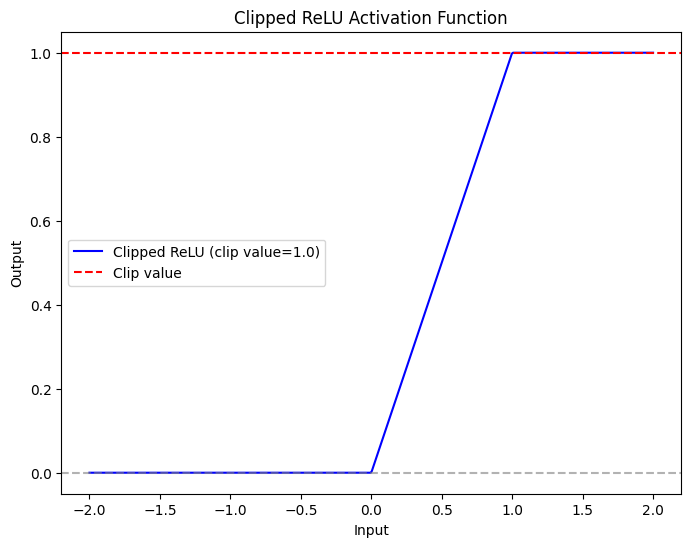

ストリーミング出力は最後の 5000 行に切り捨てられました。
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.Size([32, 500, 32])
u+y size: torch.Size([32, 25000, 32])
y_sub size: torch.

In [15]:
### 学習部分
# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# モデルのインスタンス化
N_u = 1  # 入力次元数(データによって変更)
N_x = 30 # リザバーのサイズ
N_y = 32  # 特徴量に変換
density=0.05 # リザバーの密度
clip_value = 1.0 # クリップする最大値

# モデルの作成
model = ESN(N_u=N_u, N_y=N_y, N_x=N_x, activation_func=clipped_relu).to(device) # モデルの設定 # モデルをデバイスに転送
model = model.to(torch.float32)  # モデルの浮動小数点型をfloat32

# Win, W, Wout を取得
W_in = model.Input.get_weight_matrix()
W = model.Reservoir.get_weight_matrix_W()
W_out = model.Output.get_weight_matrix_wout()

# 取得した重み行列の確認
print("Win shape:", W_in.shape)
print("W shape:", W.shape)
print("Wout shape:", W_out.shape)

# 最適化器と損失関数の設定
optimizer = optim.Adam(model.parameters(), lr=0.01) # Adamを使用
criterion = nn.CrossEntropyLoss() # クロスエントロピー損失

# 損失を記録するリスト
train_losses = [] # 訓練
val_losses = [] # 検証

# 精度を記録するリスト
train_accuracies = [] # 訓練
val_accuracies = [] # 検証

# エポック数
num_epochs = 50

### 訓練ループ
for epoch in range(num_epochs):
    model.train()  # 訓練モード
    train_outputs = []  # 訓練データの予測値(混同行列用)
    train_labels = []  # 訓練データの正解ラベル(混同行列用)
    running_loss = 0.0 # エポックごとの損失

    # エポックごとにリザバー状態をリセット
    model.reset_reservoir_state()

    # 訓練データをバッチごとに処理
    for batch_features, batch_labels in train_loader:
        batch_labels = batch_labels.long()  # ラベルを Long 型に変換

        # バッチデータをデバイスに転送
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        outputs = model(batch_features)

        # 損失計算
        loss = criterion(outputs, batch_labels)

        # バックプロパゲーション
        loss.backward()

        # パラメータの更新
        optimizer.step()

        # 損失計算
        running_loss += loss.item()

        # エポックにおける予測結果とラベルを保存
        train_outputs.extend(torch.argmax(outputs, dim=1).cpu().tolist())  # デバイスからCPUに転送してリストに変換
        train_labels.extend(batch_labels.cpu().tolist())  # 同様にCPUに転送

    # エポック毎の平均損失を計算
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 訓練制度の計算
    train_accuracy = accuracy_score(train_labels, train_outputs)
    train_accuracies.append(train_accuracy)

    # エポック毎の訓練損失, 訓練精度を表示
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")


    # 検証
    model.eval()  # 評価モード
    val_outputs = [] # 検証データの予測値
    val_labels = [] # 検証データの正解ラベル
    running_val_loss = 0.0 # 検証データの損失

    with torch.no_grad(): # 検証時は勾配計算を行わない
        for batch_features, batch_labels in val_loader:
            # データをデバイスに転送
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # 順伝播
            outputs = model(batch_features)

            # Softmaxで確率に変換
            probabilities = torch.softmax(outputs, dim=1)  # dim=1でクラス軸に沿ってSoftmaxを適用

            # 最も高い確率を持つクラスのインデックスを取得
            predicted = torch.argmax(probabilities, dim=1)

            # 予測結果とラベルを保存
            val_outputs.extend(predicted.cpu().numpy())  # CPU に転送
            val_labels.extend(batch_labels.cpu().numpy())  # 同様にCPUに転送

            # 損失計算
            loss = criterion(outputs, batch_labels)
            running_val_loss += loss.item()

    # 検証データの平均損失を計算
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # 検証制度の計算
    val_accuracy = accuracy_score(val_labels, val_outputs)
    val_accuracies.append(val_accuracy)

    # エポック毎の検証損失, 検証精度を表示
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")


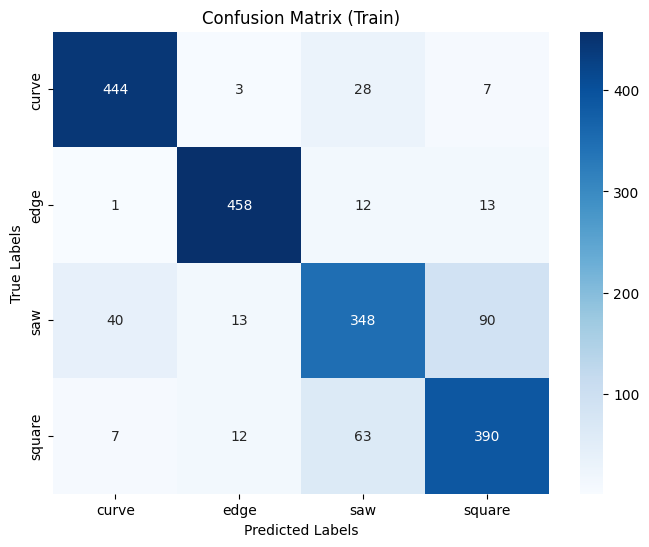

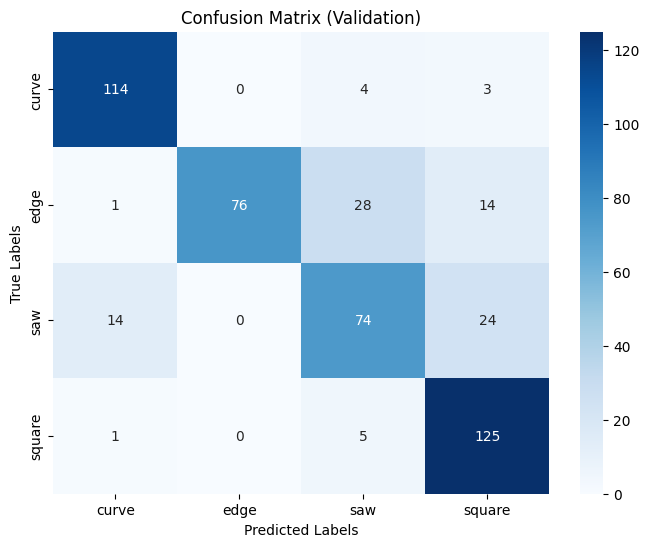

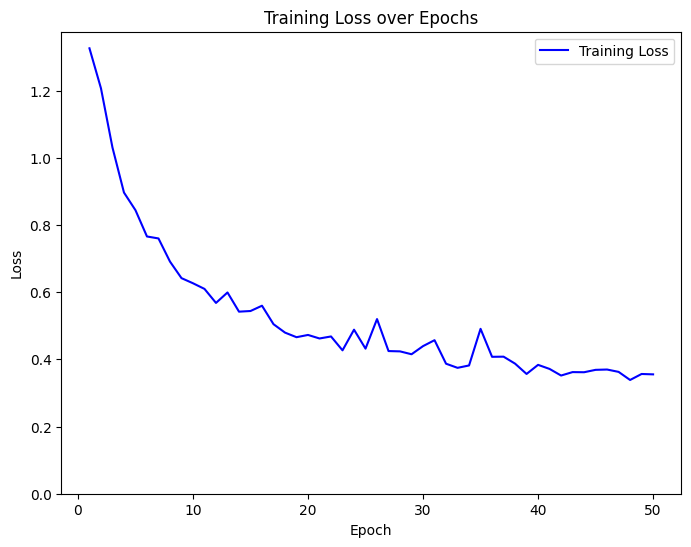

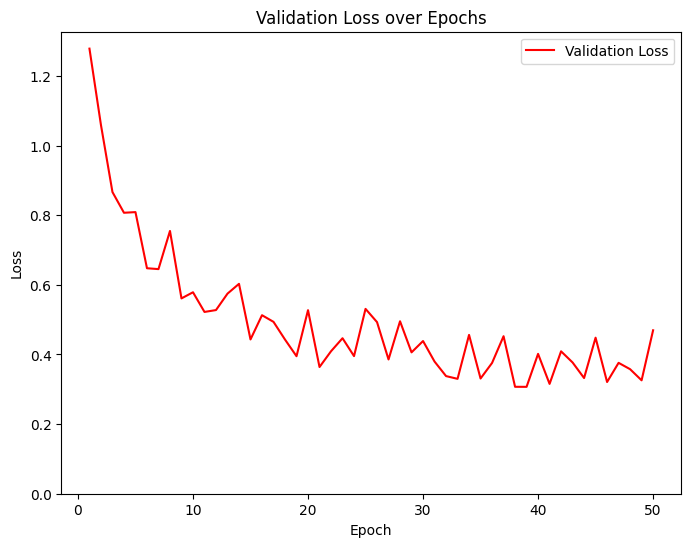

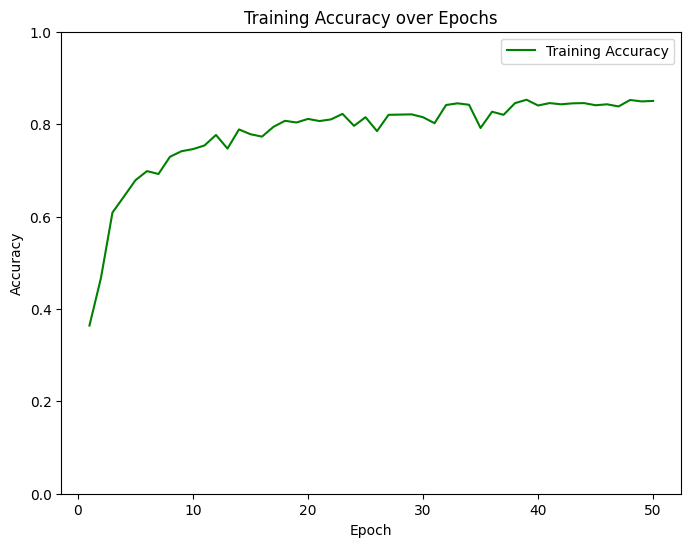

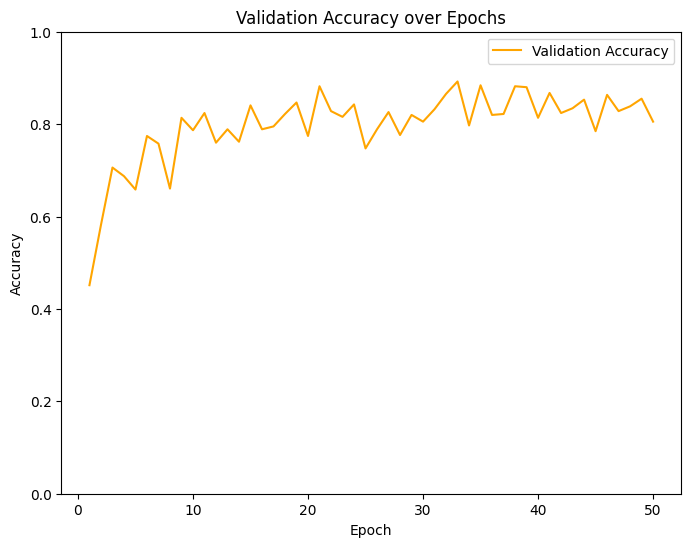

In [16]:
### 精度, 損失の可視化

# 混同行列を計算
cm_train = confusion_matrix(train_labels, train_outputs)  # 訓練データに対する混同行列
cm_val = confusion_matrix(val_labels, val_outputs)  # 検証データに対する混同行列

# マッピングから逆引き用リストを作成
# 混同行列を描画する際に使用するラベルの順番を決定
labels = [key for key, value in sorted(label_mapping.items(), key=lambda item: item[1])]


# 訓練データに対する混同行列を描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",  # 混同行列をブルー系の色で表示
            xticklabels=labels, yticklabels=labels)  # ラベル名を表示
plt.xlabel('Predicted Labels')  # x軸のラベル
plt.ylabel('True Labels')  # y軸のラベル
plt.title('Confusion Matrix (Train)')  # タイトル
plt.show()  # グラフを表示


# 検証データに対する混同行列を描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",  # 検証データの混同行列
            xticklabels=labels, yticklabels=labels)  # ラベル名を表示
plt.xlabel('Predicted Labels')  # x軸のラベル
plt.ylabel('True Labels')  # y軸のラベル
plt.title('Confusion Matrix (Validation)')  # タイトル
plt.show()  # グラフを表示


# 訓練損失のプロット
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')  # 損失をプロット
plt.xlabel('Epoch')  # x軸のラベル（エポック数）
plt.ylabel('Loss')  # y軸のラベル（損失）
plt.title('Training Loss over Epochs')  # タイトル
plt.ylim(0.0)  # y軸の下限を0に設定
plt.legend()  # 凡例を表示
plt.show()  # グラフを表示


# 検証損失のプロット
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')  # 検証損失をプロット
plt.xlabel('Epoch')  # x軸のラベル（エポック数）
plt.ylabel('Loss')  # y軸のラベル（損失）
plt.title('Validation Loss over Epochs')  # タイトル
plt.ylim(0.0)  # y軸の下限を0に設定
plt.legend()  # 凡例を表示
plt.show()  # グラフを表示


# 訓練精度のプロット
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='green')  # 訓練精度をプロット
plt.xlabel('Epoch')  # x軸のラベル（エポック数）
plt.ylabel('Accuracy')  # y軸のラベル（精度）
plt.title('Training Accuracy over Epochs')  # タイトル
plt.ylim(0, 1)  # y軸の範囲を0〜1に設定
plt.legend()  # 凡例を表示
plt.show()  # グラフを表示


# 検証精度のプロット
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')  # 検証精度をプロット
plt.xlabel('Epoch')  # x軸のラベル（エポック数）
plt.ylabel('Accuracy')  # y軸のラベル（精度）
plt.title('Validation Accuracy over Epochs')  # タイトル
plt.ylim(0, 1)  # y軸の範囲を0〜1に設定
plt.legend()  # 凡例を表示
plt.show()  # グラフを表示


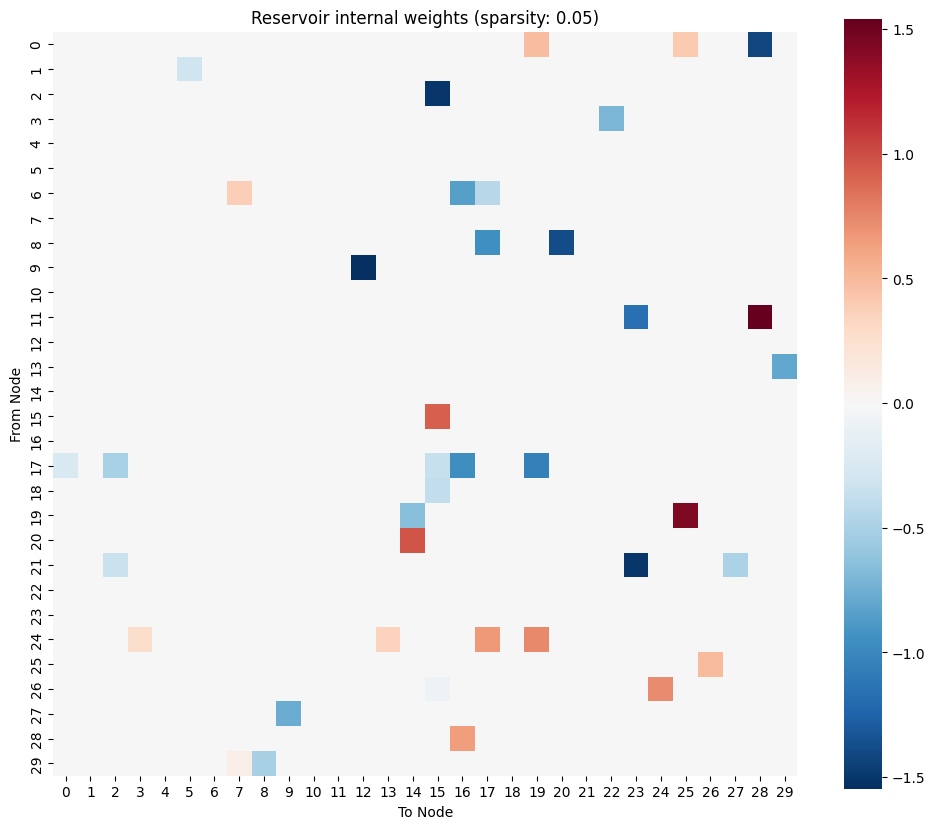

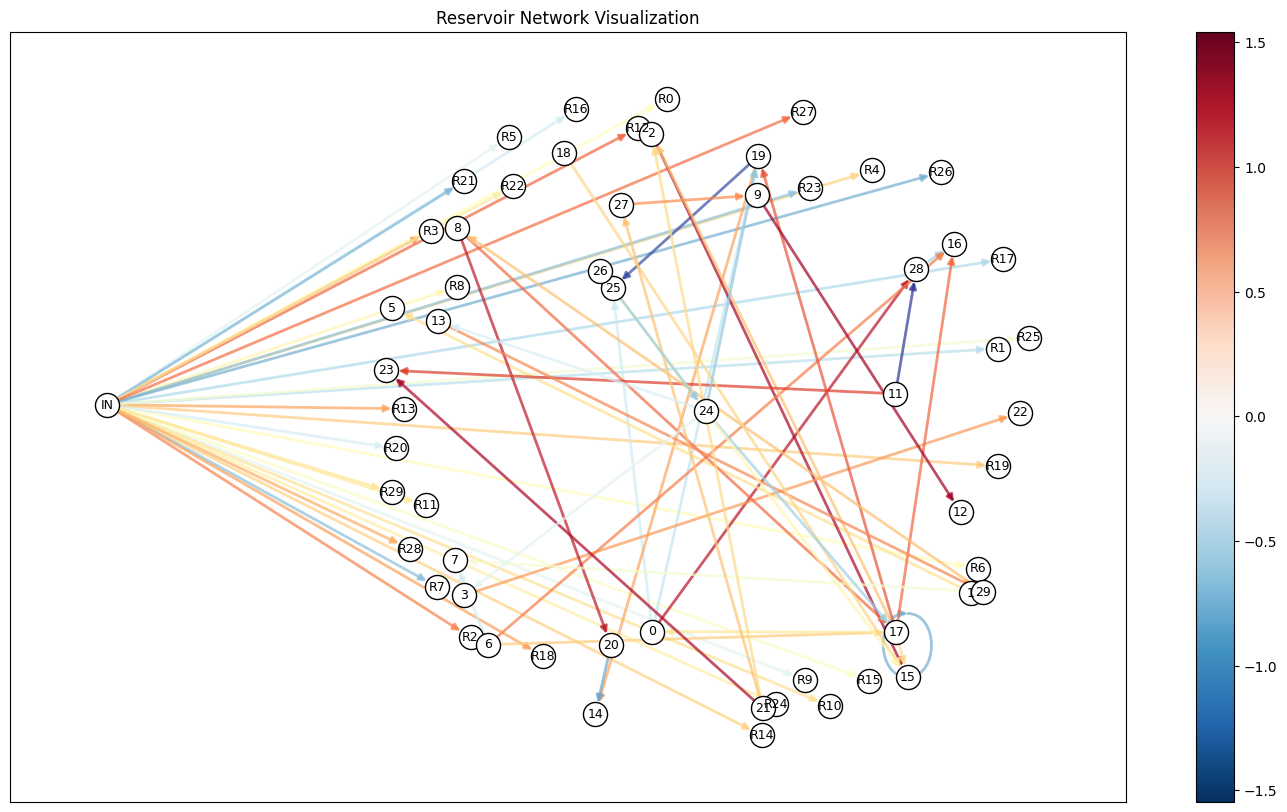

In [17]:
### ネットワークの可視化　重み行列の保存

# 重み行列を保存するためのディレクトリを作成
if not os.path.exists("results"):
    os.makedirs("results")


### ヒートマップを描画する関数
def plot_heatmap(weight_matrix, sparsity, title, filename):
    """
    重み行列のヒートマップを描画する関数。

    Parameters:
    weight_matrix (ndarray): 描画する重み行列
    sparsity (float): 重み行列のスパース性
    title (str): ヒートマップのタイトル
    filename (str): 保存するファイル名
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(weight_matrix, cmap='RdBu_r', square=True, cbar=True)
    plt.title(f'{title} (sparsity: {sparsity:.2f})')
    plt.xlabel('To Node')
    plt.ylabel('From Node')
    plt.show()


### ネットワークを可視化する関数
# outが多次元のため、入力→内部までを描画
# ノードの番号に"R"がついているものは入力重み行列の影響があるノードを表す
def visualize_network(W_in, W, W_out, N_x, threshold=0.00):
    """
    ネットワークの可視化を行う関数。

    Parameters:
    W_in (ndarray): 入力重み行列
    W (ndarray): リザバー内の重み行列
    W_out (ndarray): 出力重み行列
    N_x (int): リザバーのサイズ
    threshold (float): 重みがこの値より大きい場合にエッジを描画する
    """
    # DiGraph（有向グラフ）を作成
    G = nx.DiGraph()

    # リザバーのノードを追加
    for i in range(N_x):
        G.add_node(f'R{i}')

    # 入力ノードを追加
    G.add_node('IN')

    # W_in のノード接続を追加
    for i, w in enumerate(W_in.flatten()):
        if abs(w) > threshold:  # しきい値より大きい重みだけ描画
            G.add_edge('IN', f'R{i}', weight=w)

    # W, W_out のノード接続を追加
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if abs(W[i, j]) > threshold:  # しきい値より大きい重みだけ描画
                G.add_edge(i, j, weight=W[i, j])

    # 重みを正規化して色を決定
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    min_weight = min(weights)
    max_weight = max(weights)

    # ノードの配置（spring layoutを使用）
    pos = nx.spring_layout(G, seed=42)
    pos['IN'] = [-1.7, 0]  # 入力ノードの位置を指定

    # 重みに基づく色付け（赤から青へ）
    edge_colors = [((weight - min_weight) / (max_weight - min_weight)) for weight in weights]

    # 描画設定
    fig, ax = plt.subplots(figsize=(18, 10))

    # エッジを描画（カラーで重みによる色付け）
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, alpha=0.7, edge_cmap=plt.cm.RdYlBu)

    # ノードとラベルを描画
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='w', edgecolors='k', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    # カラーバーを追加（ヒートマップと同じカラーマップを使用）
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=plt.Normalize(W.min(), W.max()))
    mappable.set_array(weights)
    fig.colorbar(mappable, ax=ax)

    # タイトル設定
    plt.title("Reservoir Network Visualization")
    plt.show()



# 重み行列のヒートマップを描画
plot_heatmap(W.cpu().numpy(), density, "Reservoir internal weights", "results/W_heatmap.png")

# ネットワークの可視化
visualize_network(W_in.cpu().numpy(), W.cpu().numpy(), W_out.detach().cpu().numpy(), N_x, threshold=0.00)


# 重み行列の保存（float32のため、有効数字小数点以下8桁まで）
pd.DataFrame(W_in.cpu().numpy()).round(8).to_csv("results/W_in.csv", index=False, header=False)
pd.DataFrame(W.cpu().numpy()).round(8).to_csv("results/W.csv", index=False, header=False)


In [18]:
### W_inとWを表示

# 小数点以下の桁数制限を解除
torch.set_printoptions(precision=8, sci_mode=False) # 表示用

# 重みの描画
print("W_in value:", W_in)
print("W value:", W)


W_in value: Parameter containing:
tensor([[-0.00748682,  0.53644359, -0.82304513, -0.73593903, -0.38515437,
          0.26815736, -0.01981318,  0.79288948, -0.08874404,  0.26461256,
         -0.30221307, -0.19656539, -0.95534849, -0.66228211, -0.41222310,
          0.03704357,  0.39533520,  0.60002279, -0.67794108, -0.43546283,
          0.36321712,  0.83038795, -0.20580018,  0.74831176, -0.16118336,
          0.10581410,  0.90547621, -0.92767036, -0.62953794, -0.25316525]],
       device='cuda:0')
W value: Parameter containing:
tensor([[ 0.00000000, -0.00000000, -0.00000000, -0.00000000,  0.00000000,
         -0.00000000,  0.00000000,  0.00000000, -0.00000000,  0.00000000,
          0.00000000,  0.00000000, -0.00000000,  0.00000000, -0.00000000,
         -0.00000000,  0.00000000, -0.00000000, -0.00000000,  0.47564980,
          0.00000000,  0.00000000,  0.00000000,  0.00000000,  0.00000000,
          0.39701471,  0.00000000,  0.00000000, -1.41556334, -0.00000000],
        [-0.00000000

In [19]:
# 学習後の重みを取得
W_in_final = model.Input.get_weight_matrix()  # 学習後の入力重み行列
W_final = model.Reservoir.get_weight_matrix_W()  # 学習後のリザバー重み行列
W_out_final = model.Output.get_weight_matrix_wout()  # 学習後の出力重み行列

# 学習後の重みをCSVに保存
# W_in_finalの保存
df_W_in = pd.DataFrame(W_in_final.cpu().detach().numpy().round(8))
df_W_in.to_csv("W_in_final.csv", index=False, header=False)

# W_finalの保存
df_W = pd.DataFrame(W_final.cpu().detach().numpy().round(8))
df_W.to_csv("W_final.csv", index=False, header=False)

# W_out_finalの保存
df_W_out = pd.DataFrame(W_out_final.cpu().detach().numpy().round(8))
df_W_out.to_csv("W_out_final.csv", index=False, header=False)

print("学習後の重みをCSVに保存しました。")

# 学習後の重みを表示
print("学習後の入力重み行列 (W_in_final):")
print(W_in_final)
print("\n学習後のリザバー重み行列 (W_final):")
print(W_final)
print("\n学習後の出力重み行列 (W_out_final):")
print(W_out_final)

学習後の重みをCSVに保存しました。
学習後の入力重み行列 (W_in_final):
Parameter containing:
tensor([[-0.00748682,  0.53644359, -0.82304513, -0.73593903, -0.38515437,
          0.26815736, -0.01981318,  0.79288948, -0.08874404,  0.26461256,
         -0.30221307, -0.19656539, -0.95534849, -0.66228211, -0.41222310,
          0.03704357,  0.39533520,  0.60002279, -0.67794108, -0.43546283,
          0.36321712,  0.83038795, -0.20580018,  0.74831176, -0.16118336,
          0.10581410,  0.90547621, -0.92767036, -0.62953794, -0.25316525]],
       device='cuda:0')

学習後のリザバー重み行列 (W_final):
Parameter containing:
tensor([[ 0.00000000, -0.00000000, -0.00000000, -0.00000000,  0.00000000,
         -0.00000000,  0.00000000,  0.00000000, -0.00000000,  0.00000000,
          0.00000000,  0.00000000, -0.00000000,  0.00000000, -0.00000000,
         -0.00000000,  0.00000000, -0.00000000, -0.00000000,  0.47564980,
          0.00000000,  0.00000000,  0.00000000,  0.00000000,  0.00000000,
          0.39701471,  0.00000000,  0.00000000,